An attempt to recall logistic regression using pytorch on a mock dataset. 

In [137]:
from sklearn.datasets import make_blobs
import torch
import matplotlib.pyplot as plt
import numpy as np

In [146]:
X,Y = make_blobs(n_samples=500, n_features=2, cluster_std=3, centers=2, random_state=42)

X = torch.tensor(X, dtype=torch.float64)
Y = torch.tensor(Y, dtype = torch.int64)

print(X.dtype, Y.dtype)

torch.float64 torch.int64


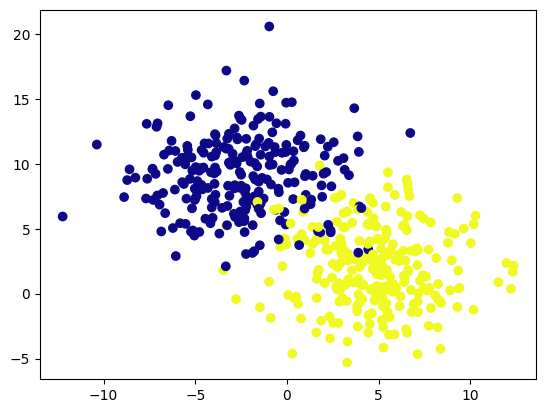

In [105]:
def visualize(X,Y):
    plt.scatter(X[:,0], X[:,1], c = Y, cmap='plasma')
    plt.show()
    return

visualize(X,Y)

So now we have the arrays X and Y. SO now lets init a network, which since its LR, will be a single layer with weights `W` and bias `b`. We will execute the forward pass, apply sigmoid activation and define loss and the call loss.backward() to update weights of our layer and improve performance across iterations. 

Lets do some thinking. 

X.shape = (500,2)<br>
Y.shape = (500,)<br>

W = w1x1 + w2x2 + b <br>

In [158]:
g = torch.Generator().manual_seed(3445432)

W = torch.randn((2,2), requires_grad=True, dtype=torch.float64, generator=g) #* 1/torch.sqrt(torch.tensor(2.))
b = torch.randn((2,), requires_grad=True, dtype=torch.float64,  generator=g) #*0.1
parameters = [W,b]

In [148]:
W.dtype, X.dtype, b.dtype

(torch.float64, torch.float64, torch.float64)

Oh boy, these datatypes matching really sucked the marrow out of me. Spent like 1.5 hours getting them all to match and then execute as expected. Phew

Also:<br>
init like: `b = torch.randn((2,), requires_grad=True, dtype=torch.float64,  generator=g) *0.1` makes `b` a non-leaf tensor because of multiplication with a scalar, which supercedes the original setting of `requires_grad=True` . And hence, backward() will not attribute a grad to `b`. This is some intricate shit. 

In [157]:
lossi = []

In [164]:
max_iters = 400
lr = 0.1

for i in range(max_iters):
    # forward pass 
    logits = X@W + b
    loss = torch.nn.functional.cross_entropy(logits, target = Y)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.item())
    if i%40 ==0:
        print(loss.item())



0.12830953344533735
0.1283048271454574
0.12830051314715804
0.12829655793195346
0.12829293094474598
0.12828960431963304
0.12828655263258823
0.12828375267819475
0.12828118326793145
0.1282788250477908


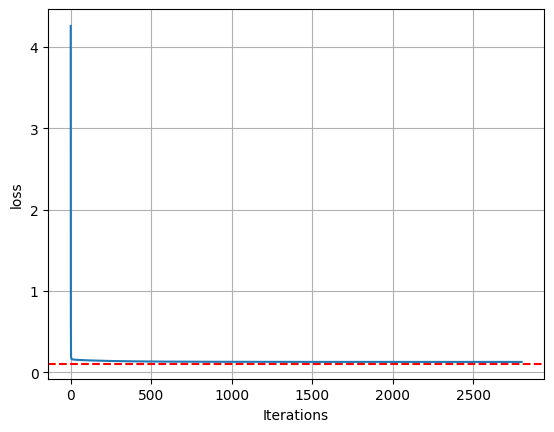

In [165]:
def plot_loss(loss, threshold):
    plt.plot(loss)
    plt.axhline(y=threshold, color='r', linestyle='--', label='y = 0.13')
    plt.xlabel('Iterations')
    plt.ylabel('loss')
    plt.grid(True)
    plt.show()

plot_loss(lossi, 0.1)

The above implementation with cross entropy loss follows __2-class softmax + cross_entropy__ approach. Instead we could have had __1 output neuron + BCEWithLogitsLoss__ which is more intuitive. 

In [166]:
with torch.no_grad():  # no need to track gradients for inference
    trained_logtis = X @ W + b  # shape: (500, 2)
    predictions = torch.argmax(trained_logtis, dim=1)  # shape: (500,)


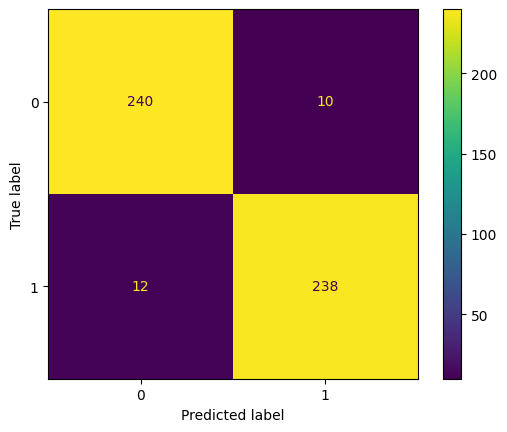

In [171]:
# confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = Y.numpy()
y_pred = predictions.numpy()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [168]:
# using GPT to visuzlize the decision boundary 

def plot_decision_boundary(X, Y, W, b):
    X_np = X.numpy()
    Y_np = Y.numpy()

    # Plot data points
    plt.figure(figsize=(5,5))
    plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_np, cmap=plt.cm.coolwarm, edgecolors='k')

    # Create a meshgrid over the feature space
    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=W.dtype)

    # Compute logits and predicted classes
    with torch.no_grad():
        logits = grid @ W + b
        preds = torch.argmax(logits, dim=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, preds.numpy(), alpha=0.2, cmap=plt.cm.coolwarm)
    plt.title("Decision Boundary")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True)
    plt.show()


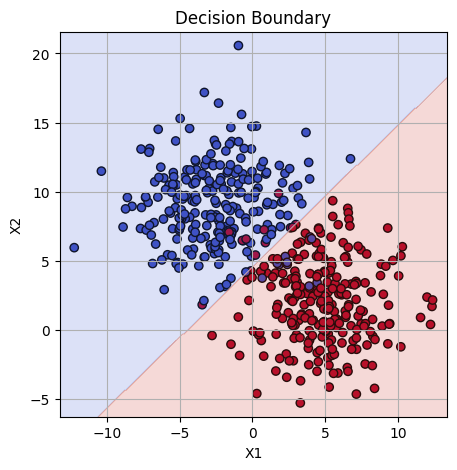

In [169]:
plot_decision_boundary(X, Y, W, b)